In [1]:
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt

from backflip import *
from local_augmentations import *

# Backflip main function

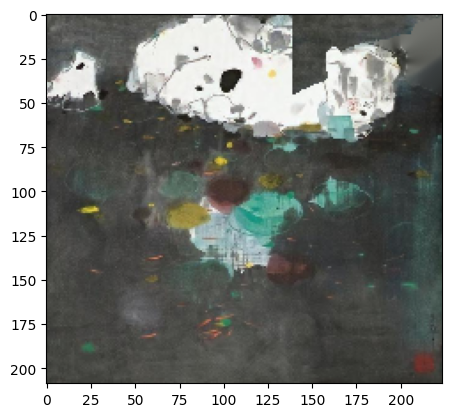

In [207]:
def backflip(img: np.ndarray, img_name: str, possible_aug: list, aug_prob: list, num_of_segments: int, segment_dir: str = 'segments',
             inpaint_method: str = 'telea') -> np.ndarray:
    """
    Apply backflip augmentation to an image.

    Args:
        img (np.ndarray): The input image.
        img_name (str): The name of the image.
        possible_aug (list): List of possible augmentation functions.
        aug_prob (list): List of probabilities for each augmentation function.
        num_of_segments (int): Number of segments to select for augmentation.
        segment_dir (str, optional): Directory where the segments are stored. Defaults to 'segments'.
        inpaint_method (str, optional): Inpainting method to fill the background. Defaults to 'telea'.

    Returns:
        np.ndarray: The augmented image.
    """
    
    # Check inpaint method
    if inpaint_method not in ['telea', 'ns', 'mean', 'median']:
        raise ValueError('Inpaint method not recognized.')

    # Get the segment names
    folder_name = img_name[:img_name.rfind('.')]
    segment_names = [f for f in os.listdir(os.path.join(segment_dir, folder_name)) if os.path.isfile(os.path.join(segment_dir, folder_name, f))]

    # Selected segments
    if num_of_segments > len(segment_names):
        selected_segments = segment_names
    else:
        selected_segments = np.random.choice(segment_names, num_of_segments, replace=False)

    unchanged_img = img.copy()

    # Augmentation loop
    for segment in selected_segments:
        # Opening mask
        mask = cv2.imread(os.path.join(segment_dir, folder_name, segment))
        mask_bool = mask.any(axis=2).astype(bool)

        # Filling background
        if inpaint_method == 'telea':
            mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            inpaint = cv2.inpaint(img, mask_gray, 3, cv2.INPAINT_TELEA)
            img[mask_bool] = inpaint[mask_bool]
        elif inpaint_method == 'ns':
            mask_gray = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
            inpaint = cv2.inpaint(img, mask_gray, 3, cv2.INPAINT_NS)
            img[mask_bool] = inpaint[mask_bool]
        elif inpaint_method == 'mean':   
            edges = cv2.subtract(cv2.dilate(mask, np.ones((6, 6), np.uint8), iterations=2), mask)
            edges = cv2.bitwise_and(img, edges)
            median_color = np.mean(edges[edges.sum(axis=2) > 0], axis=0)
            img[mask_bool] = median_color
        elif inpaint_method == 'median':
            mask_bool = mask.any(axis=2).astype(bool)
            edges = cv2.subtract(cv2.dilate(mask, np.ones((6, 6), np.uint8), iterations=2), mask)
            edges = cv2.bitwise_and(img, edges)
            median_color = np.median(edges[edges.sum(axis=2) > 0], axis=0)
            img[mask_bool] = median_color

        # # Augmenting the segment
        bbox = get_segment_bounding_box(mask)
        cut_img = unchanged_img[bbox['min_y']:bbox['max_y'], bbox['min_x']:bbox['max_x']]
        cut_mask = mask[bbox['min_y']:bbox['max_y'], bbox['min_x']:bbox['max_x']]

        selected_augmentation = np.random.choice(possible_aug, p=aug_prob)
        augmented_segment = selected_augmentation(cut_img, cut_mask)

        # Inserting the augmented segment
        img = insert_element(img, augmented_segment['img'], augmented_segment['mask'], (bbox['center_y'], bbox['center_x']))

        return img


image_name = 'wu-guanzhong_fishes-1986.png'
img = cv2.cvtColor(cv2.imread(os.path.join('resized_images', image_name)), cv2.COLOR_BGR2RGB)

h = backflip(img, image_name, [hor_flip, ver_flip], [0.5, 0.5], 1, inpaint_method='telea')

plt.imshow(img)
plt.show()